In [1]:
import networkx as nx

from pmotifs.config import config

In [2]:
import os

ppi_networks_dir = config.DATASET_DIRECTORY / "some_PPI_networks"

In [3]:
def parse_ppi_tsv(tsv):
    return nx.read_edgelist(
        tsv,
        delimiter="\t",
        data=[
            ("node1_string_id", str),
            ("node2_string_id", str),
            ("neighborhood_on_chromosome", float),
            ("gene_fusion", float),
            ("phylogenetic_cooccurrence", float),
            ("homology", float),
            ("coexpression", float),
            ("experimentally_determined_interaction", float),
            ("database_annotated", float),
            ("automated_textmining", float),
            ("combined_score", float),
        ],
    )

In [4]:
networks = {
    n: parse_ppi_tsv(ppi_networks_dir / n)
    for n in os.listdir(ppi_networks_dir)
}

In [5]:
MAX_EDGES = 2000

# Preproc Logic

In [6]:
def rewrite_name(n):
    return n.replace("_string_interactions_short.tsv", "")

In [7]:
def get_largest_component(g):
    max_c = None
    for c in nx.connected_components(g):
        if max_c is None:
            max_c = c
        
        if len(c) > len(max_c):
            max_c = c
    return max_c

In [8]:
def remove_edges(g, edges, err_on_not_exist=False):
    for u, v in edges:
        if g.has_edge(u, v) or err_on_not_exist:
            g.remove_edge(u, v)

In [9]:
def fit_graph_return_component(original_g, max_edges, score_field="combined_score"):
    """Increases cutoff until the largest component has max_edges or less edges"""
    if max_edges < 0:
        raise ValueError("Can not reduce graph to less than 0 edges!")
    
    g = original_g.copy()
    del original_g

    scores_to_edges = {}
    for edge, value in nx.get_edge_attributes(g, name=score_field).items():
        scores_to_edges[value] = scores_to_edges.get(value, []) + [edge]

    total_edge_count = len(g.edges)
    unique_scores_sorted = sorted(scores_to_edges.keys())
    
    cutoff_value = None
    induced_graph = nx.induced_subgraph(g, get_largest_component(g))

    if len(induced_graph.edges) <= max_edges:
        return induced_graph, cutoff_value

    for cutoff_value in unique_scores_sorted:
        remove_edges(g, scores_to_edges[cutoff_value])
        induced_graph = nx.induced_subgraph(g, get_largest_component(g))
        
        if len(induced_graph.edges) <= max_edges:
            break

    return induced_graph, cutoff_value

In [10]:
from pmotifs.gtrieScanner.graph_io import write_shifted_edgelist

for n, g in networks.items():
    print(rewrite_name(n))
    new_g, cutoff = fit_graph_return_component(g, MAX_EDGES)
    print(f"{len(g.edges)} --> {len(new_g.edges)} (cutoff: {cutoff})")
    if not nx.is_connected(new_g) or len(new_g) > MAX_EDGES:
        print("FAIL")
    
    out = config.DATASET_DIRECTORY / f"{rewrite_name(n)}_cutoff_{cutoff}.edgelist"
    write_shifted_edgelist(new_g, out, reindex=True)

human_memory_all
522 --> 521 (cutoff: None)
ecoli_metabolism_macromol
10414 --> 1992 (cutoff: 0.939)
human_cancer
19730 --> 1992 (cutoff: 0.935)
human_celldeath
15758 --> 1973 (cutoff: 0.938)
human_cellcycleGO
37751 --> 1952 (cutoff: 0.987)
human_brain_development
8824 --> 1996 (cutoff: 0.772)
human_alzheimerskegg
8680 --> 1873 (cutoff: 0.977)
ecoli536_signaling
552 --> 552 (cutoff: None)


In [11]:
"""Tie breaking logic"""
from typing import Callable, List

def filter_graphs(graphs: List[nx.Graph], score_calulator: Callable[nx.Graph, float], pick_min=False):
    scores = [score_calulator(g) for g in graphs]
    target_score = min(scores) if pick_min else max(scores)
    
    return [
        g
        for g in graphs
        if score_calulator(g) == target_score
    ]
    
def pick_subgraph(subgraphs):
    """Choose component by highest edge_count, or if tied, by lowest node count, or if tied again, by index"""
    max_edge_count_graphs = filter_graphs(subgraphs, lambda g: len(g.edges))
    if len(max_edge_count_graphs) == 1:
        return max_edge_count_graphs[0]
    min_node_count_graphs = filter_graphs(subgraphs, lambda g: len(g.nodes), pick_min=True)
    
    # Return only result or the result with the smallest index
    return min_node_count_graphs[0]
    

In [12]:
from tqdm import tqdm


def fit_any_component(original_g, max_edges, score_field="combined_score"):
    """Increases cutoff until any component has max_edges or lower edges (with tiebreaking)"""
    if max_edges < 0:
        raise ValueError("Can not reduce graph to less than 0 edges!")
    
    g = original_g.copy()
    del original_g

    scores_to_edges = {}
    for edge, value in nx.get_edge_attributes(g, name=score_field).items():
        scores_to_edges[value] = scores_to_edges.get(value, []) + [edge]

    total_edge_count = len(g.edges)
    unique_scores_sorted = sorted(scores_to_edges.keys())
    cutoff_value = None
    
    valid_component_subgaphs = [
        nx.induced_subgraph(g, component)
        for component in nx.connected_components(g)
        if len(nx.induced_subgraph(g, component).edges) <= max_edges
    ]
    if len(valid_component_subgaphs) > 0:
        print("Early abort")
        return pick_subgraph(valid_component_subgaphs), cutoff_value
    
    # Find cutoff value to create at least one valid component (below 2000 edges)
    for cutoff_value in unique_scores_sorted:
        remove_edges(g, scores_to_edges[cutoff_value])

        valid_component_subgaphs = [
            nx.induced_subgraph(g, component)
            for component in nx.connected_components(g)
            if len(nx.induced_subgraph(g, component).edges) <= max_edges
        ]
        if len(valid_component_subgaphs) > 0:
            break
        
    return pick_subgraph(valid_component_subgaphs), cutoff_value

In [13]:
for n, g in networks.items():
    print(rewrite_name(n))
    new_g, cutoff = fit_any_component(g, MAX_EDGES)
    print(f"{len(g.edges)} --> {len(new_g.edges)} (cutoff: {cutoff})")

human_memory_all
Early abort
522 --> 521 (cutoff: None)
ecoli_metabolism_macromol
Early abort
10414 --> 41 (cutoff: None)
human_cancer
Early abort
19730 --> 1 (cutoff: None)
human_celldeath
15758 --> 0 (cutoff: 0.403)
human_cellcycleGO
37751 --> 0 (cutoff: 0.413)
human_brain_development
Early abort
8824 --> 1 (cutoff: None)
human_alzheimerskegg
8680 --> 0 (cutoff: 0.803)
ecoli536_signaling
Early abort
552 --> 552 (cutoff: None)


In [14]:
def filter_with_fixed_value(original_g, min_value, score_field="combined_score"):
    """Filters edges against a fixed cutoff, returning the largest component"""
    
    g = original_g.copy()
    del original_g

    edges = list(g.edges(data=score_field))
    for u, v, score in edges:
        if score < min_value:
            g.remove_edge(u, v)
    return nx.induced_subgraph(g, get_largest_component(g))
    

In [15]:
for n, g in networks.items():
    print(rewrite_name(n))
    new_g = filter_with_fixed_value(g, 0.8)
    print(f"{len(g.edges)} --> {len(new_g.edges)}")

human_memory_all
522 --> 94
ecoli_metabolism_macromol
10414 --> 3647
human_cancer
19730 --> 4278
human_celldeath
15758 --> 4366
human_cellcycleGO
37751 --> 12466
human_brain_development
8824 --> 1858
human_alzheimerskegg
8680 --> 5160
ecoli536_signaling
552 --> 180


In [16]:
import matplotlib.pyplot as plt

def visualize_edge_development(original_g, ax, score_field="combined_score"):
    # Plot the edge development of the largest component
    g = original_g.copy()
    del original_g

    scores_to_edges = {}
    for edge, value in nx.get_edge_attributes(g, name=score_field).items():
        scores_to_edges[value] = scores_to_edges.get(value, []) + [edge]

    total_edge_count = len(g.edges)
    unique_scores_sorted = sorted(scores_to_edges.keys())
    
    
    edges = [len(nx.induced_subgraph(g, get_largest_component(g)).edges)]
    for score in unique_scores_sorted:
        remove_edges(g, scores_to_edges[score])
        edges.append(len(nx.induced_subgraph(g, get_largest_component(g)).edges))
        
    ax.plot(edges)

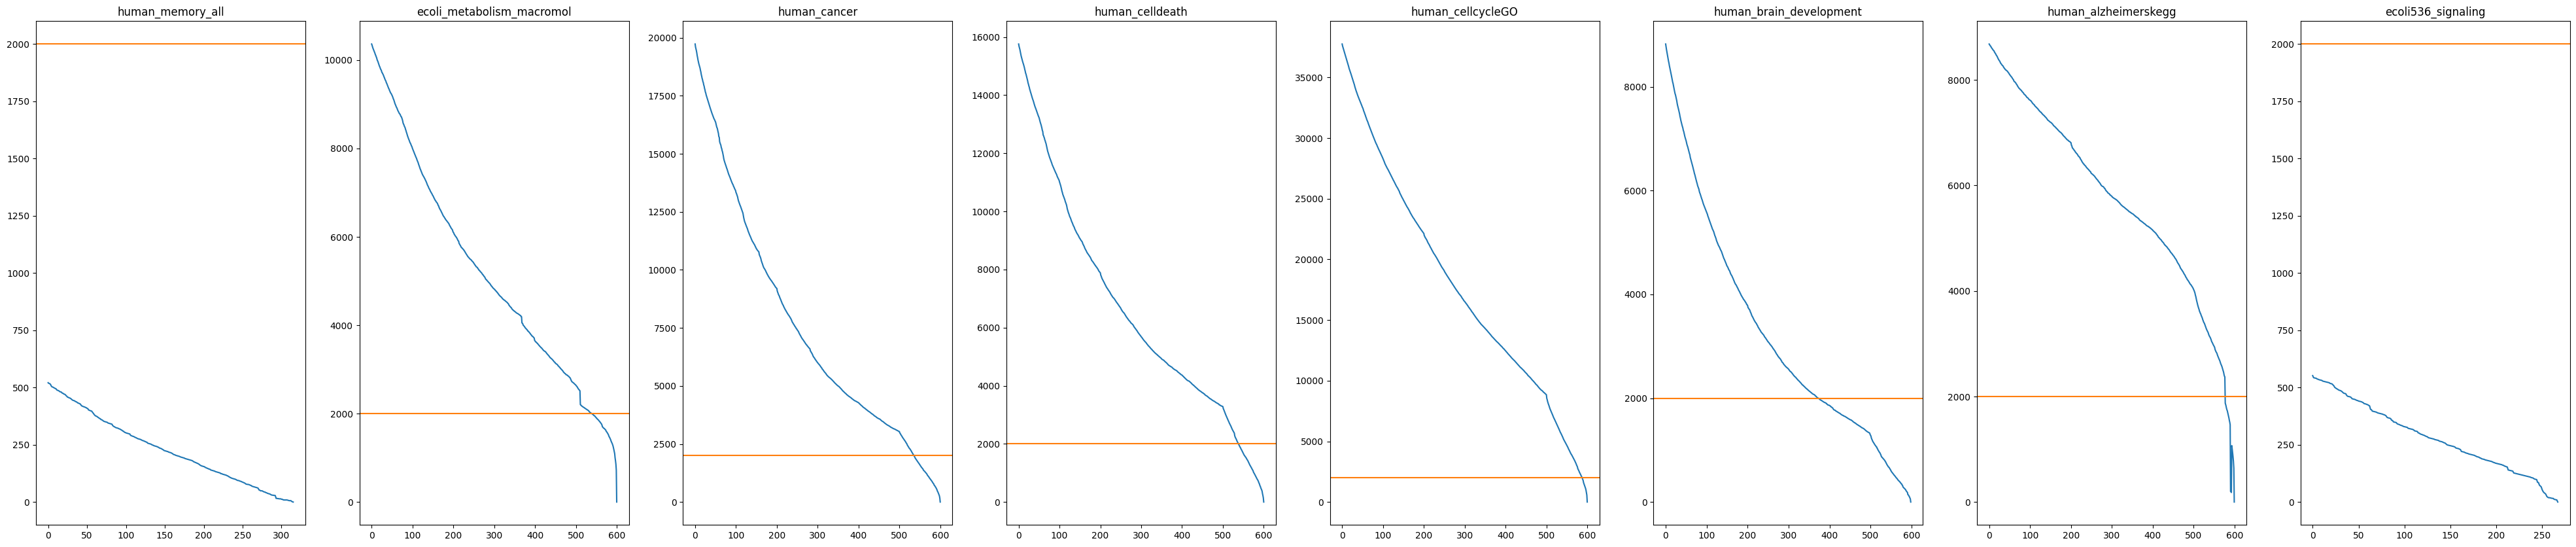

In [17]:
desired_edges = 2000

fig, axes = plt.subplots(1, len(networks), figsize=(50, 10))
for i, (n, g) in enumerate(networks.items()):
    ax = axes[i]
    visualize_edge_development(g, ax)
    ax.axhline(desired_edges, color="tab:orange")
    ax.set_title(n.replace("_string_interactions_short.tsv", ""))